# Assign 2 - Deep Learning
Jonathan Menahem - 203772611 <br>
Alon Mazri - 311503841

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import imagesize
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.layers.experimental.preprocessing as preprocessing

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading The Data

In [3]:
image_size=(256, 256)
train_directory = 'chest_xray/train'
test_directory = 'chest_xray/test'
seed = np.random.randint(50, dtype=int)

# these are all default input values from documentation
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size,
    shuffle=True, seed=seed, validation_split=0.15, subset='training',
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size, 
    shuffle=True, seed=seed, validation_split=0.15, subset='validation',
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

# these are all default input values from documentation
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size,
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5232 files belonging to 2 classes.
Using 4448 files for training.
Found 5232 files belonging to 2 classes.
Using 784 files for validation.
Found 624 files belonging to 2 classes.


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = validation_data.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_data.map(lambda x, y: (normalization_layer(x), y))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
train_labels = np.array([])

for x, y in train_data:
    train_labels = np.concatenate([train_labels, np.argmax(y.numpy(), axis = -1)])

val_labels =  np.array([])

for x, y in validation_data:
    val_labels = np.concatenate([val_labels, np.argmax(y.numpy(), axis = -1)])

test_labels =  np.array([])

for x, y in test_data:
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])


print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Labels Shape:", test_labels.shape)

Train Labels Shape: (4448,)
Validation Labels Shape: (784,)
Test Labels Shape: (624,)


In [7]:
train_cases_count = np.unique(train_labels, return_counts=True)
val_cases_count = np.unique(val_labels, return_counts=True)
test_cases_count = np.unique(test_labels, return_counts=True)

total_cases_count = train_cases_count[1] + val_cases_count[1] + test_cases_count[1]

COUNT_NORMAL = total_cases_count[0]
COUNT_PNEUMONIA = total_cases_count[1]
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA

In [8]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.85
Weight for class 1: 0.69


## Transfer Learning
### resnet, densenet, inception, efficientnet

[Transfer Learning Tensorflow](https://www.tensorflow.org/tutorials/images/transfer_learning)

[Example using Resnet50](https://www.kaggle.com/abhishekdhule/pneumonia-detection-resnet-inception-tensorflow#Model-2-(ResNet-50))

[Example using Resnet50 #2](https://www.kaggle.com/satyaprakash13820/implementing-resnet-architecture)

### ResNet152 - Last Layer Training

In [9]:
from tensorflow.keras.applications import ResNet152

num_classes = 2
input_shape = (256, 256, 3)

pretrained_resnet = ResNet152(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling=None, classes=1000)

#freazing the trained layers
for layers in pretrained_resnet.layers:
    layers.trainable = False

pretrained_resnet.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [10]:
last_layer = pretrained_resnet.get_layer('conv5_block3_1_relu')
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

resnet_model = tf.keras.Model(pretrained_resnet.input, x)

METRICS = ['accuracy']

resnet_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [12]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

resnet_history = resnet_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, verbose=2)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 - 33s - loss: 0.5069 - accuracy: 0.7412 - val_loss: 0.4141 - val_accuracy: 0.7946 - lr: 0.0010 - 33s/epoch - 234ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 - 24s - loss: 0.3750 - accuracy: 0.8121 - val_loss: 0.3506 - val_accuracy: 0.8265 - lr: 8.5000e-04 - 24s/epoch - 170ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 - 22s - loss: 0.3285 - accuracy: 0.8568 - val_loss: 0.3287 - val_accuracy: 0.8533 - lr: 6.1413e-04 - 22s/epoch - 160ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 - 20s - loss: 0.3053 - accuracy: 0.8858 - val_loss: 0.3157 - val_accuracy: 0.8686 - lr: 3.7715e-04 - 20s/epoch - 143ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


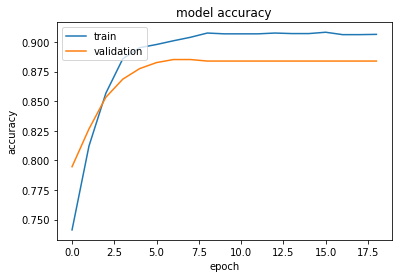

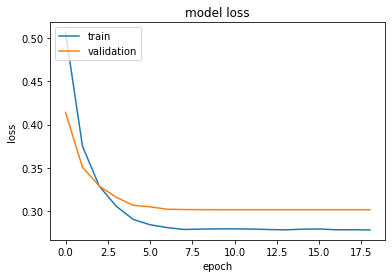

In [13]:
# list all data in history
print(resnet_history.history.keys())
# summarize history for accuracy
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
loss, accuracy = resnet_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 3s 118ms/step - loss: 0.5936 - accuracy: 0.7212
Test loss: 0.5936057567596436
Test accuracy: 0.7211538553237915


In [15]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(resnet_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


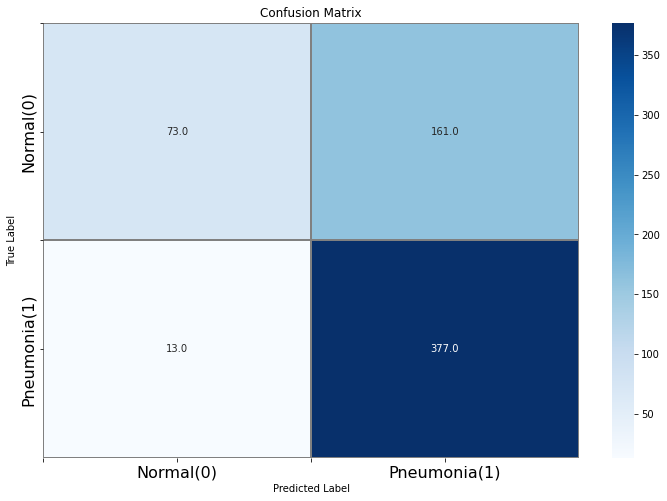

In [16]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.31      0.46       234
         1.0       0.70      0.97      0.81       390

    accuracy                           0.72       624
   macro avg       0.77      0.64      0.63       624
weighted avg       0.76      0.72      0.68       624



### ResNet152 - Middle Layer Training